In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal


from mr_complex_resonator import MR_complex_resonator as MR_complex_resonator
from mr_lekid import MR_LEKID as MR_LEKID
import utils




colormap = plt.cm.gnuplot
colormap2 = plt.cm.viridis
colormap3 = plt.cm.turbo
colormap4 = plt.cm.summer_r


def to_dbm(x):
    return 10*np.log10(1e3*x)

def to_W(x):
    return 10**(x/10.) * 1e-3


plt.rcParams.update({'xtick.labelsize' : '18'})
plt.rcParams.update({'ytick.labelsize' : '18'})
plt.rcParams.update({'legend.fontsize' : '13'})
plt.rcParams.update({'font.size' : '18'})
plt.rcParams.update({'axes.formatter.useoffset' : 'False'})
plt.rcParams['axes.grid'] = True

## generating a resonator and plotting its transfer function


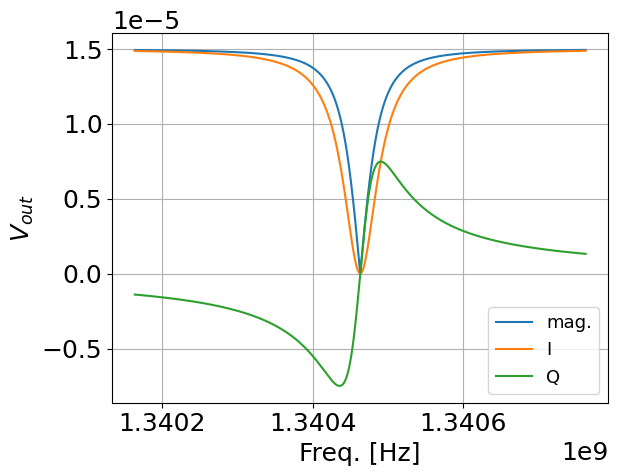

In [3]:
res = MR_complex_resonator() 

fr = res.lekid.compute_fr()

span = 300e3
frange = np.linspace(fr-span, fr+span, 1000)
Vout = res.lekid.compute_Vout(frange)
plt.plot(frange, abs(Vout), label='mag.')
plt.plot(frange, Vout.real, label='I')
plt.plot(frange, Vout.imag, label='Q')

plt.ylabel('$V_{out}$')
plt.xlabel('Freq. [Hz]')
plt.legend()

### under different optical loads

note that the default behaviour is to determine Lg based on $alpha_k$, so if you are going to change the loading, you should establish Lg from a low-load model, then fix it at this value

Text(0.5, 0, 'Freq. [Hz]')

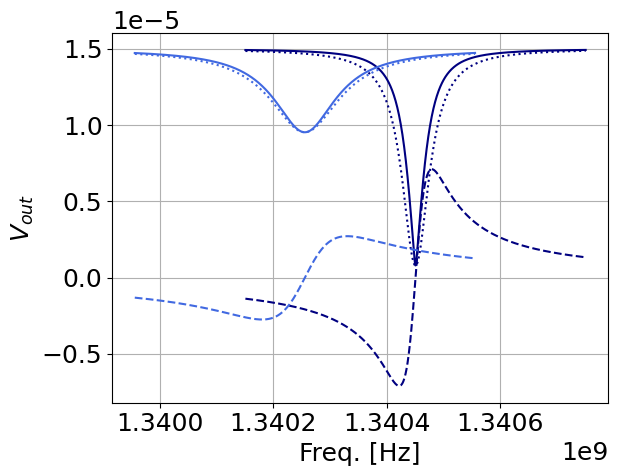

In [5]:
dark_Popt = 1e-15
sky_Popt = 1e-12

darkcolour = 'navy'
skycolour = 'royalblue'

baseline_res = MR_complex_resonator(Popt=dark_Popt, alpha_k=0.5)
Lg = baseline_res.Lg 


# resonator under dark conditions
res = MR_complex_resonator(Popt=dark_Popt, fix_Lg=Lg)
fr = res.lekid.compute_fr()

span = 300e3
frange = np.linspace(fr-span, fr+span, 1000)
Vout = res.lekid.compute_Vout(frange)
plt.plot(frange, abs(Vout), color=darkcolour, label='mag.')
plt.plot(frange, Vout.real, ':', color=darkcolour, label='I')
plt.plot(frange, Vout.imag, '--', color=darkcolour, label='Q')



# resonator under sky conditions
res = MR_complex_resonator(Popt=sky_Popt, fix_Lg=Lg)
fr = res.lekid.compute_fr()

span = 300e3
frange = np.linspace(fr-span, fr+span, 1000)
Vout = res.lekid.compute_Vout(frange)
plt.plot(frange, abs(Vout), color=skycolour, label='mag.')
plt.plot(frange, Vout.real, ':', color=skycolour, label='I')
plt.plot(frange, Vout.imag, '--', color=skycolour, label='Q')


plt.ylabel('$V_{out}$')
plt.xlabel('Freq. [Hz]')

### temperature



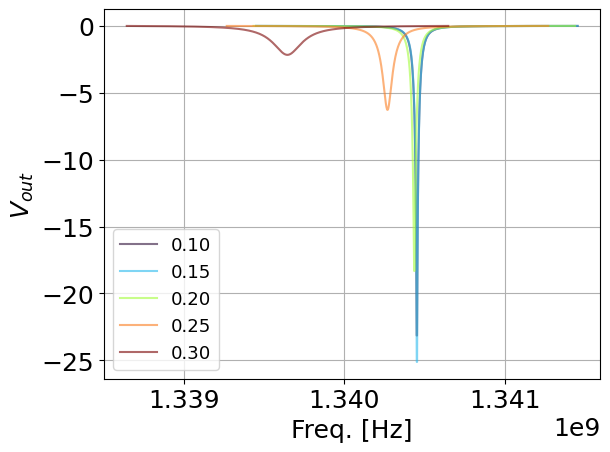

In [17]:
Trange = np.linspace(0.1, 0.3, 5)
Popt = 1e-15


baseline_res = MR_complex_resonator(Popt=1e-15, alpha_k=0.5)
Lg = baseline_res.Lg 

for T in Trange:
    plotcolour = colormap3((T-min(Trange)) / (max(Trange) - min(Trange)))
    # resonator under dark conditions
    res = MR_complex_resonator(Popt=Popt, T=T, fix_Lg=Lg)
    fr = res.lekid.compute_fr()
    
    span = 1e6
    frange = np.linspace(fr-span, fr+span, 1000)
    Vout = res.lekid.compute_Vout(frange)
    mag_db = 20*np.log10(abs(Vout)/abs(Vout[-1]))
    plt.plot(frange, mag_db, color=plotcolour, alpha=0.6, label='%.2f'%T)



plt.ylabel('$V_{out}$')
plt.xlabel('Freq. [Hz]')
plt.legend()

## generate noise

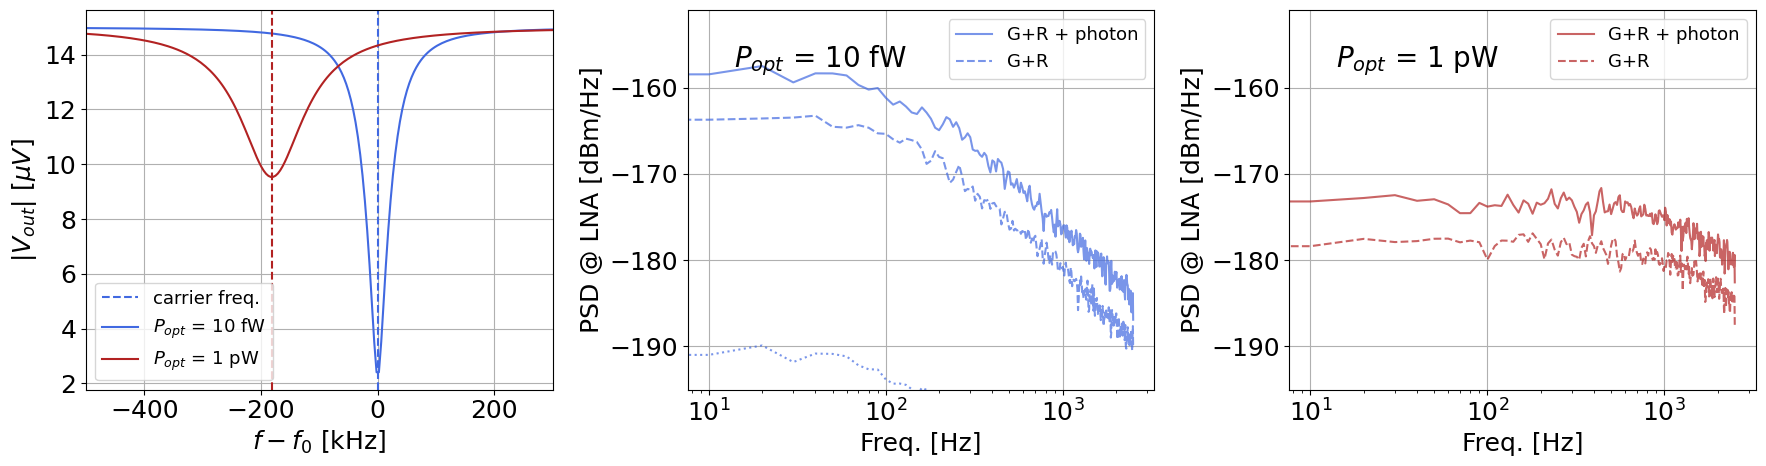

In [29]:


res = MR_complex_resonator()
Lg = res.lekid.Lg

fig = plt.figure(figsize=(6*3, 5))
ax = fig.add_subplot(131)
bx = fig.add_subplot(132)
cx = fig.add_subplot(133)
Prange = [1e-14, 1e-12]

noise_frange = np.logspace(-2, 4, 100)

plotcolours = ['royalblue', 'firebrick']

for p, Popt in enumerate(Prange):
    if p == 1:
        noise_plot = cx
    else:
        noise_plot = bx
    res = MR_complex_resonator(fix_Lg=Lg, Popt=Popt)
    fr = res.lekid.compute_fr()

    # put the carrier at the resonant frequency (or somewhere else if you want!)
    carrier_freq = fr
    if p == 0:
        fr0 = fr
        clabel = 'carrier freq.'
    else:
        clabel = ''
    ax.axvline(1e-3*(carrier_freq-fr0), linestyle='--', color=plotcolours[p], label=clabel)
    
    
    span = 2000e3
    frange = np.linspace(fr-span, fr+span, 1000)
    
    plotfreq = 1e-3*(frange - fr0)
    Vout = res.lekid.compute_Vout(frange)
    if p == 0:
        plabel = '$P_{opt}$ = 10 fW'
    else:
        plabel = '$P_{opt}$ = 1 pW'
    ax.plot(plotfreq, 1e6*abs(Vout), color=plotcolours[p], label=plabel)
    

    fs = 5e3
    N = int(5e3)
    rbw = fs/N
    

    # comute spectrum for total resonator noise (GR + generation due to photon shot noise)
    # generate qp number fluctuation spectral density 
    frequencies = np.fft.fftfreq(N, d=1./fs)
    frequencies, Nqp_spectrum_gr = res.calc_gr_PSD_thermal_optical(frange=frequencies, nu_opt=150e9) 
    # turn number fluctuation spectral density into timestream of qp number density values
    nqp_timestream_gr = utils.make_nqp_timestream_from_Nqp_spectrum(res, frequencies=frequencies, Nqp_spectrum=Nqp_spectrum_gr,
                                                                       rbw=rbw, baseline_nqp=res.calc_nqp())
    # put these nqp values through the resonance, and compute the resulting voltage timestream that the carrier "saw"
    Vout_timestream_gr = res.make_carrier_Vout_timestream_for_nqp_timestream(nqp_timestream=nqp_timestream_gr, fs=fs, N=N)
    # orientation of the IQ plane is arbitary, so might as well rotate the timestream as we do IRL, to put max response in Q direction
    Vout_timestream_gr, _ = utils.rotate_iq_plane(Vout_timestream_gr)
    
    psdfreq, psdi = signal.welch(Vout_timestream_gr.real/np.sqrt(50.), fs=fs, nperseg=N/10)
    psdfreq, psdq = signal.welch(Vout_timestream_gr.imag/np.sqrt(50.), fs=fs, nperseg=N/10)
    
    
    noise_plot.plot(psdfreq, to_dbm(psdi), ':', alpha=0.7, color=plotcolours[p])
    noise_plot.plot(psdfreq, to_dbm(psdq), alpha=0.7, color=plotcolours[p], label='G+R + photon')

    
    
    # thermalized GR only
    frequencies = np.fft.fftfreq(N, d=1./fs)
    frequencies, Nqp_spectrum_gr = res.calc_gr_PSD(frange=frequencies) 
    nqp_timestream_gr = utils.make_nqp_timestream_from_Nqp_spectrum(res, frequencies=frequencies, Nqp_spectrum=Nqp_spectrum_gr,
                                                                       rbw=rbw, baseline_nqp=res.calc_nqp())
    Vout_timestream_gr = res.make_carrier_Vout_timestream_for_nqp_timestream(nqp_timestream=nqp_timestream_gr, fs=fs, N=N)
    Vout_timestream_gr, _ = utils.rotate_iq_plane(Vout_timestream_gr)
    
    psdfreq, psdi = signal.welch(Vout_timestream_gr.real/np.sqrt(50.), fs=fs, nperseg=N/10)
    psdfreq, psdq = signal.welch(Vout_timestream_gr.imag/np.sqrt(50.), fs=fs, nperseg=N/10)
    noise_plot.plot(psdfreq, to_dbm(psdi), '--', alpha=0.7, color=plotcolours[p])
    noise_plot.plot(psdfreq, to_dbm(psdq), '--', alpha=0.7, color=plotcolours[p], label='G+R')
    
    noise_plot.text(0.1, 0.85, '%s'%plabel, fontsize=20, transform=noise_plot.transAxes)
    

    
ax.set_ylabel('$|V_{out}|$ [$\mu V$]')
ax.set_xlabel('$f - f_0$ [kHz]')
ax.legend(loc='lower left')
ax.set_xlim(-500, 300)


for x in [bx, cx]:    
    x.set_xscale('log')
    x.set_ylim(-195, -151)
    x.set_ylabel('PSD @ LNA [dBm/Hz]')
    x.set_xlabel('Freq. [Hz]')
    x.legend(loc='upper right')
    
fig.tight_layout()